# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Dynamics of Disease Transmission and Human Behavior Project
## CS109B: Advanced Topics in Data Science



**Harvard University**<br/>
**Spring 2022**<br/>
**Team members**: Di Zhen, Yujie Zhang, and Xinyun Stacy Li


<hr style="height:2pt">

# 1. Introduction
COVID-19 has caused a global impact since its outbreak in 2019. Various of efforts have been spent to predict and prevent the transmission of the virus. Some conducted time-series predicting of COVID-19 cases and deaths based on daily confirmed cases and deaths using deep neural network (Alassafi, Madini O et al., 2022). Others also incorporated features indicating human interactions, human mobility, and socioeconomic compositions of countries to make the prediction (Vahedi, B., Karimzadeh, M. & Zoraghein, H., 2021). Here in this project, we explored and examined the effectiveness of predicting COVID-19 cases using Google trends. Given its potentially sensitive and fast reaction, Google trend pattern could provide important signals for the following changes in the number of COVID-19 cases and deaths. 


We have two goals to achieve:
1. Use the Google search activity trends data within a certain window to predict the COVID-19 confirmed cases trends.

1. Recognize the complications of COVID-19 through Google search trends. This secondary goal can be achieved by interpreting the model for the first goal and identify important features. 

1. Test the generalizability of the model (cross-states, cross-diseases)

We propose applying neural network models including simple RNN, LSTM, and bidirectional LSTM to predict the confirmed COVID-19 cases for the following 7 days based on the Google trend data within 2 weeks. We focus on predictions for three states including California, New York, and Massachusetts, which are metropolitan representatives of the eastern and western U.S. The large populations in these states provide a clear picture of the transmission pattern of the virus over time. Moreover, we are also interested in the most predictive trends for these states and whether the model built from one state could generalize to the other two states.

In [ ]:
import os
import random as rn
import tensorflow as tf
import pandas as pd
import numpy as np
import missingno as meso
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import KNNImputer
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Flatten, Dropout, Bidirectional, TimeDistributed, Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, GridSearchCV

# Import class for reservoir computing
# from pyESN import ESN # Written by user cknd: https://github.com/cknd/pyESN
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.random.set_seed(109)
np.random.seed(109)
rn.seed(109)

# 2. Exploratory Data Analysis (EDA), Data Cleaning, and Feature Selection


The data we are working on contains a set of time-series records spanned nearly two years where each set corresponds to a state. This data is also used by another group for early COVID-19 warning approach (Kogan, Nicole E et al., 2021). The features of the data are mainly Google trends patterns for a suite of COVID-19-related terms. The data also contains dates, JHU confirmed COVID-19 cases, deaths and hospitalization. JHU-cases are the reported COVID-19 cases on the John Hopkins platform. Same with deaths and hospitalizations.

## Load packages and three datasets from California, New York, and Massachusetts


In [ ]:
california = pd.read_csv("./drive/MyDrive/CS109 Project/state_level_data/California.csv",parse_dates=['date'],index_col=['date'])
new_york = pd.read_csv("./drive/MyDrive/CS109 Project/state_level_data/New York.csv",parse_dates=['date'],index_col=['date'])
ma = pd.read_csv("./drive/MyDrive/CS109 Project/state_level_data/Massachusetts.csv",parse_dates=['date'],index_col=['date'])

In [ ]:
print(california.tail(10)) # remove the final 5 days since it's NA
print(new_york.tail(10)) # remove the final 5 days since it's NA
print(ma.tail(10)) # remove the final 5 days since it's NA

            JHU_cases  JHU_deaths  JHU_hospitalizations  up2date  \
date                                                               
2022-01-04    76786.0        94.0                1679.0      NaN   
2022-01-05    39356.0       126.0                1768.0      NaN   
2022-01-06    86590.0        32.0                1950.0      NaN   
2022-01-07   108391.0       234.0                1950.0      NaN   
2022-01-08    34364.0        17.0                1973.0      NaN   
2022-01-09        NaN         NaN                   NaN      NaN   
2022-01-10        NaN         NaN                   NaN      NaN   
2022-01-11        NaN         NaN                   NaN      NaN   
2022-01-12        NaN         NaN                   NaN      NaN   
2022-01-13        NaN         NaN                   NaN      NaN   

            gt_after covid vaccine  gt_side effects of vaccine  \
date                                                             
2022-01-04              606.538018                 

In [ ]:
california = california.iloc[:-5, :]
new_york = new_york.iloc[:-5, :]
ma = ma.iloc[:-5, :]

## Have a glimps of the basic characteristics of the features in three datasets

In [ ]:
california.describe()

,JHU_cases,JHU_deaths,JHU_hospitalizations,up2date,gt_after covid vaccine,gt_side effects of vaccine,gt_effects of covid vaccine,gt_covid,gt_how long does covid last,gt_anosmia,...,neighbor_South Dakota,neighbor_Tennessee,neighbor_Texas,neighbor_Utah,neighbor_Vermont,neighbor_Virginia,neighbor_Washington,neighbor_West Virginia,neighbor_Wisconsin,neighbor_Wyoming
count,718.000000,718.000000,544.000000,416.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,...,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000
mean,8408.796657,107.302228,654.398897,266.588302,1031.942497,267.194675,185.924657,90028.915062,261.722963,29.050446,...,263.803621,2037.598886,6963.263231,949.910864,106.435933,1700.607242,1296.756267,495.643454,1651.902507,166.931755
std,12651.020881,138.156802,557.909209,194.928115,1390.723867,345.901801,257.298072,48033.048924,261.124650,55.944590,...,377.790566,3500.653803,9728.762811,1276.364174,238.298140,2672.792276,2221.208234,696.125703,2286.520080,248.876616
min,-3935.000000,-364.000000,116.000000,0.305869,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-4.000000,-42.000000,0.000000,0.000000,-1.000000,-232.000000,-39.000000,-4.000000,0.000000,-8.000000
25%,1808.000000,25.000000,321.000000,148.166794,0.000000,0.000000,0.000000,59592.925370,85.080935,0.000000,...,8.000000,80.250000,1405.250000,164.000000,4.000000,338.500000,179.000000,37.250000,170.000000,4.000000
50%,4261.500000,71.000000,432.500000,218.744994,452.973872,106.062503,76.018212,85254.949587,202.678864,0.000000,...,103.000000,1138.500000,4353.500000,469.500000,28.500000,985.000000,662.000000,245.000000,722.500000,59.000000
75%,9263.500000,126.000000,767.250000,372.607233,1545.638911,433.671560,303.376619,119532.223229,343.857587,74.962550,...,391.750000,2448.250000,9097.250000,1342.250000,133.000000,1947.500000,1644.750000,800.500000,2457.750000,214.000000
max,133669.000000,1174.000000,2580.000000,1038.286656,7638.661166,2015.938064,1288.312759,279350.860227,1762.854735,489.629451,...,3047.000000,41464.000000,162871.000000,14754.000000,2779.000000,40246.000000,33069.000000,9164.000000,16956.000000,1541.000000


In [ ]:
new_york.describe()

,JHU_cases,JHU_deaths,JHU_hospitalizations,up2date,gt_after covid vaccine,gt_side effects of vaccine,gt_effects of covid vaccine,gt_covid,gt_how long does covid last,gt_anosmia,...,neighbor_South Dakota,neighbor_Tennessee,neighbor_Texas,neighbor_Utah,neighbor_Vermont,neighbor_Virginia,neighbor_Washington,neighbor_West Virginia,neighbor_Wisconsin,neighbor_Wyoming
count,718.000000,718.000000,628.000000,413.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,...,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000
mean,5650.603064,84.179666,338.020701,273.848046,1040.784629,258.155170,185.922481,81814.132416,241.301710,29.192104,...,263.803621,2037.598886,6963.263231,949.910864,106.435933,1700.607242,1296.756267,495.643454,1651.902507,166.931755
std,10578.020047,158.428439,346.426180,204.442332,1441.508179,369.787387,273.820223,45337.817828,280.248919,99.552451,...,377.790566,3500.653803,9728.762811,1276.364174,238.298140,2672.792276,2221.208234,696.125703,2286.520080,248.876616
min,0.000000,-39.000000,0.000000,0.386998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-4.000000,-42.000000,0.000000,0.000000,-1.000000,-232.000000,-39.000000,-4.000000,0.000000,-8.000000
25%,761.250000,11.000000,76.750000,119.990235,0.000000,0.000000,0.000000,54180.221043,0.000000,0.000000,...,8.000000,80.250000,1405.250000,164.000000,4.000000,338.500000,179.000000,37.250000,170.000000,4.000000
50%,3244.000000,33.000000,248.000000,212.882174,449.697206,122.064574,0.000000,75948.414719,164.538827,0.000000,...,103.000000,1138.500000,4353.500000,469.500000,28.500000,985.000000,662.000000,245.000000,722.500000,59.000000
75%,6820.250000,85.750000,501.000000,429.083090,1482.680957,387.813498,321.704245,110109.874172,347.628994,0.000000,...,391.750000,2448.250000,9097.250000,1342.250000,133.000000,1947.500000,1644.750000,800.500000,2457.750000,214.000000
max,132093.000000,1271.000000,1822.000000,851.288126,7497.319619,1960.105672,1492.312072,252855.272209,1658.316674,1688.992891,...,3047.000000,41464.000000,162871.000000,14754.000000,2779.000000,40246.000000,33069.000000,9164.000000,16956.000000,1541.000000


In [ ]:
ma.describe()

,JHU_cases,JHU_deaths,JHU_hospitalizations,up2date,gt_after covid vaccine,gt_side effects of vaccine,gt_effects of covid vaccine,gt_covid,gt_how long does covid last,gt_anosmia,...,neighbor_South Dakota,neighbor_Tennessee,neighbor_Texas,neighbor_Utah,neighbor_Vermont,neighbor_Virginia,neighbor_Washington,neighbor_West Virginia,neighbor_Wisconsin,neighbor_Wyoming
count,718.000000,718.000000,545.000000,405.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,...,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000
mean,1782.629526,28.646240,95.385321,205.606450,1259.189524,320.039049,179.927457,105515.003634,286.690899,35.198203,...,263.803621,2037.598886,6963.263231,949.910864,106.435933,1700.607242,1296.756267,495.643454,1651.902507,166.931755
std,3216.080237,38.875802,84.255750,152.465206,1982.132662,538.107816,387.776484,54954.359511,432.199234,142.216509,...,377.790566,3500.653803,9728.762811,1276.364174,238.298140,2672.792276,2221.208234,696.125703,2286.520080,248.876616
min,-280.000000,-41.000000,0.000000,0.641865,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-4.000000,-42.000000,0.000000,0.000000,-1.000000,-232.000000,-39.000000,-4.000000,0.000000,-8.000000
25%,177.000000,4.000000,33.000000,86.110279,0.000000,0.000000,0.000000,73935.025457,0.000000,0.000000,...,8.000000,80.250000,1405.250000,164.000000,4.000000,338.500000,179.000000,37.250000,170.000000,4.000000
50%,844.500000,16.000000,71.000000,158.658515,394.101640,0.000000,0.000000,103733.371863,0.000000,0.000000,...,103.000000,1138.500000,4353.500000,469.500000,28.500000,985.000000,662.000000,245.000000,722.500000,59.000000
75%,2104.250000,37.750000,114.000000,331.885371,1683.065283,533.900996,0.000000,135524.614482,523.685463,0.000000,...,391.750000,2448.250000,9097.250000,1342.250000,133.000000,1947.500000,1644.750000,800.500000,2457.750000,214.000000
max,33090.000000,302.000000,415.000000,733.953110,11797.230235,3703.701740,2755.424717,326875.861998,2695.132985,1285.819388,...,3047.000000,41464.000000,162871.000000,14754.000000,2779.000000,40246.000000,33069.000000,9164.000000,16956.000000,1541.000000


In [ ]:
california.shape, new_york.shape, ma.shape

((739, 498), (739, 498), (739, 498))

## Plot the number of cases, deaths and hospitalizations of COVID-19 against time for each state
In order to visualize the trend of COVID-19 cases from Jan 2020, the beginning of the dataset, to Jan 2022, the end of the dataset, we made the following plots for the three states. We noticed that there were negative numbers of cases in the plot, which were likely to be errors in the record. We changed them to 0s later in the data cleaning.

Text(0.5, 1.0, 'COVID-19 cases over time in Massachusetts')

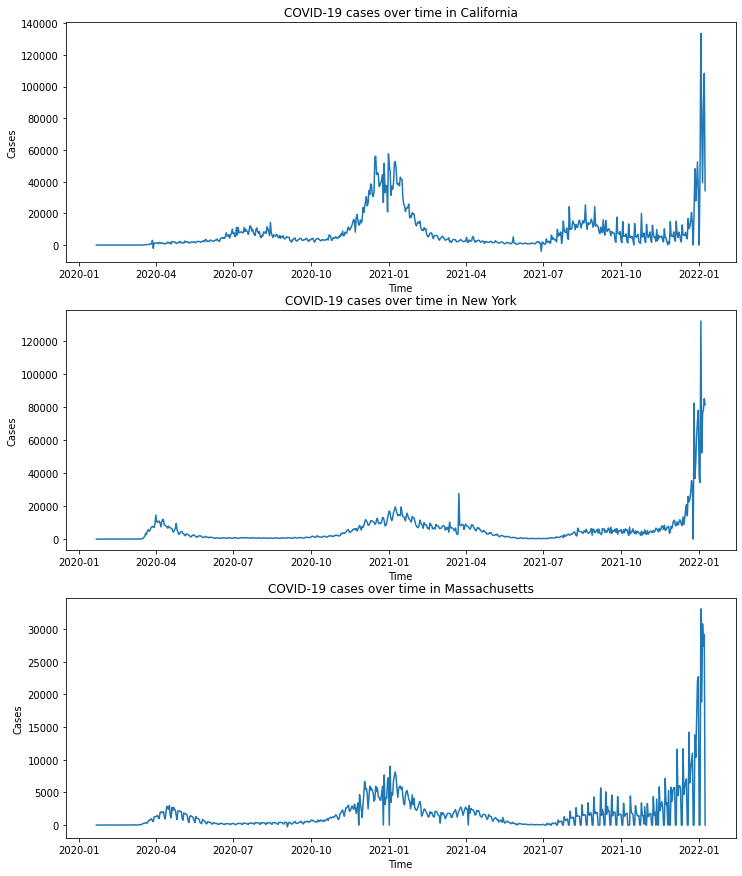

In [ ]:
fig,axs = plt.subplots(3,1, figsize = (12,15))
axs[0].plot(california.index.values, california['JHU_cases'])
axs[1].plot(new_york.index.values, new_york['JHU_cases'])
axs[2].plot(ma.index.values, ma['JHU_cases'])
for i in range(3):
  axs[i].set_xlabel('Time')
axs[0].set_ylabel('Cases')
axs[1].set_ylabel('Cases')
axs[2].set_ylabel('Cases')
axs[0].set_title('COVID-19 cases over time in California')
axs[1].set_title('COVID-19 cases over time in New York')
axs[2].set_title('COVID-19 cases over time in Massachusetts')


## Visualize the distribution of missing values in the features for three states
A bunch of features missing after the first year. We removed them later in the data cleaning since their missingness was too high.

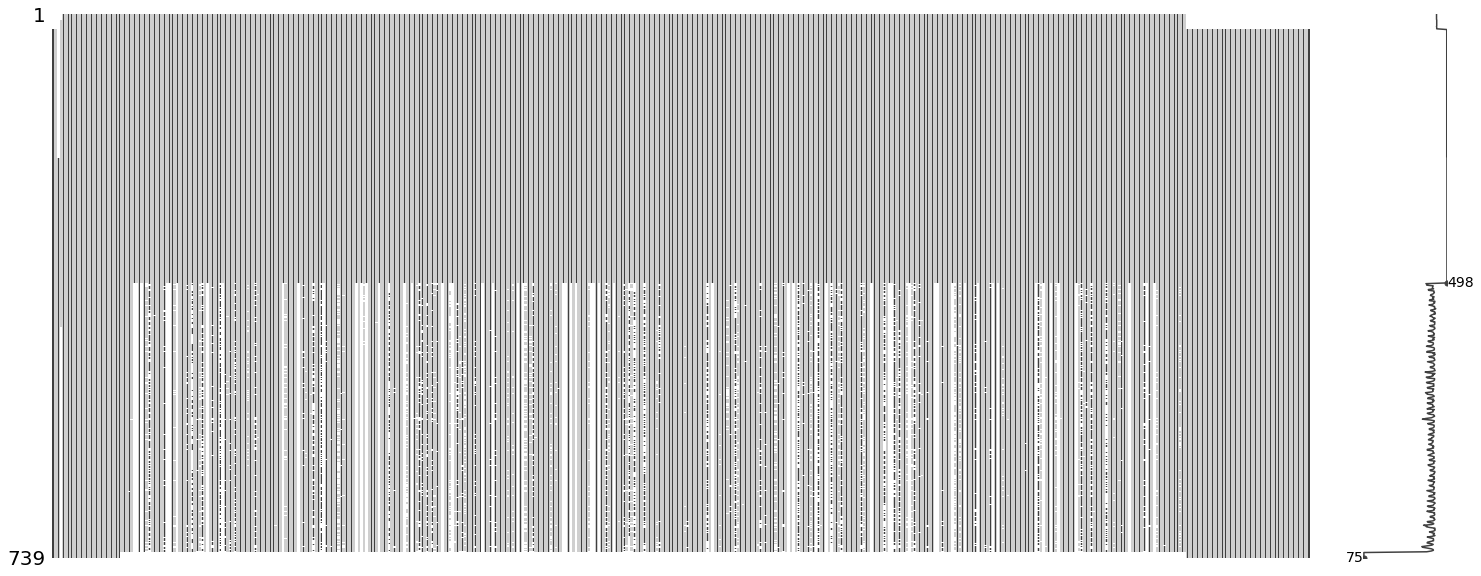

In [ ]:
meso.matrix(california)

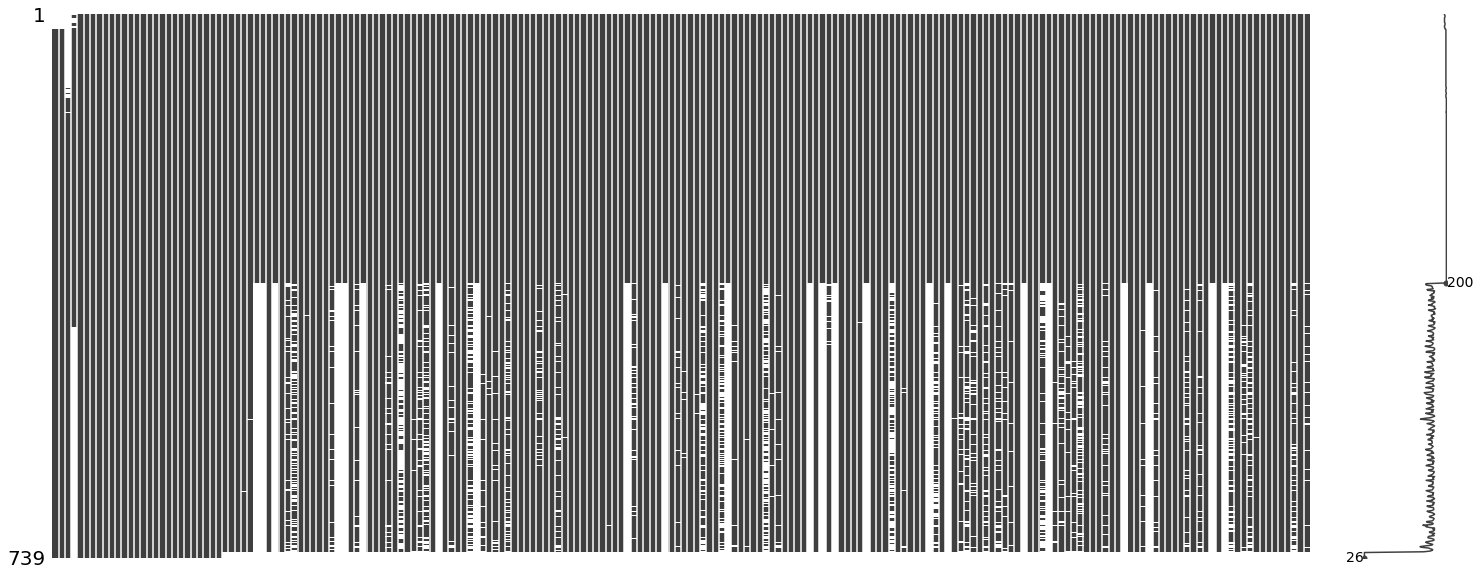

In [ ]:
meso.matrix(new_york.iloc[:,:200])

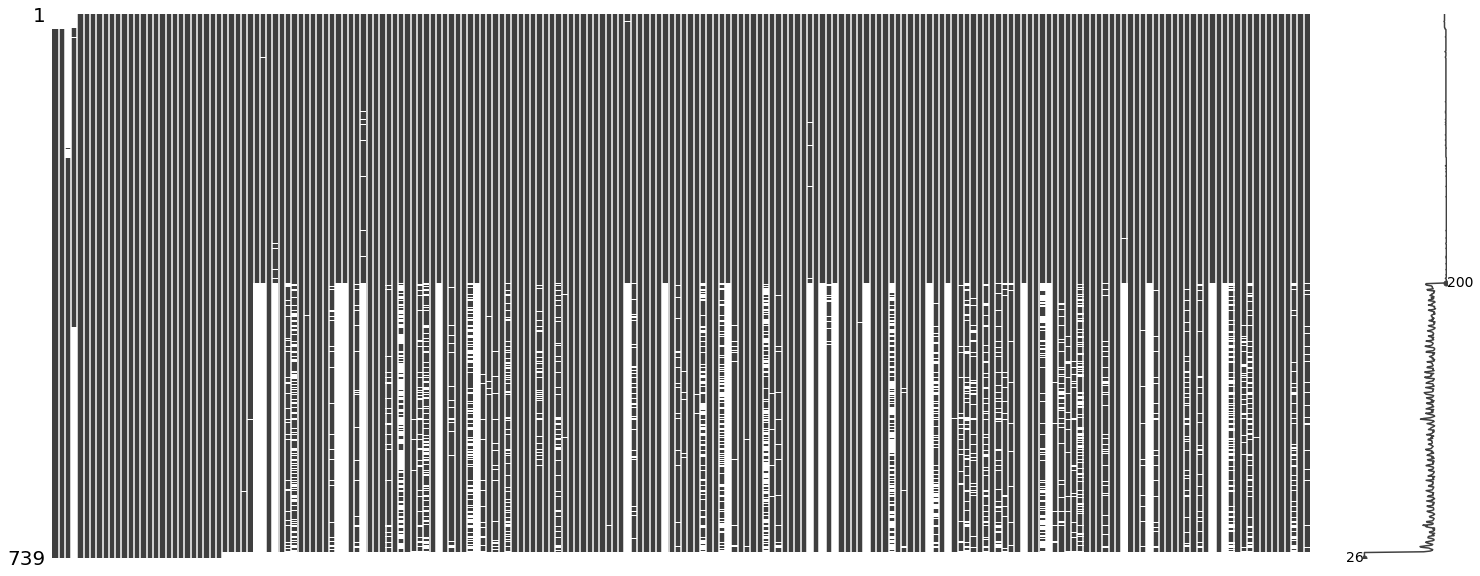

In [ ]:
meso.matrix(ma.iloc[:,:200])


## Drop features with large missing values and flip the sign of negative cases

We chose to drop features with more than roughly 20% (100) missing values. After that, we lost 88 features, which wasn't a huge deduction compared to the total number of features we had. We didn't lose a lot of information here.

We observed that most of NAs are at the beginning of the padamic, so we believe the number of cases/deaths are 0 or close to 0. Therefore, we decided to replace nan with 0 in cases/deaths. We also flipped the sign of negative number of cases with 0s, because they are likely to be erroneous data.

In [ ]:
for state in [california, new_york, ma]:
  state['JHU_cases']=state['JHU_cases'].fillna(0)
  print(state['JHU_cases'][state['JHU_cases'] < 0])

date
2020-03-29   -2019.0
2021-06-29   -3935.0
Name: JHU_cases, dtype: float64
Series([], Name: JHU_cases, dtype: float64)
date
2020-09-03   -280.0
Name: JHU_cases, dtype: float64


In [ ]:
california['JHU_cases'][california['JHU_cases'] == -2019.0] = 2019.0
california['JHU_cases'][california['JHU_cases'] == -3935.0] = 3935.0
ma['JHU_cases'][ma['JHU_cases'] == -280.0] = 280

In [ ]:
california.shape, new_york.shape, ma.shape

((739, 498), (739, 498), (739, 498))


## Sanity check the cleaning step by visualization

After data cleaning, we plotted the number of cases of all three states against time to check that all cases were positive and had similar trend.

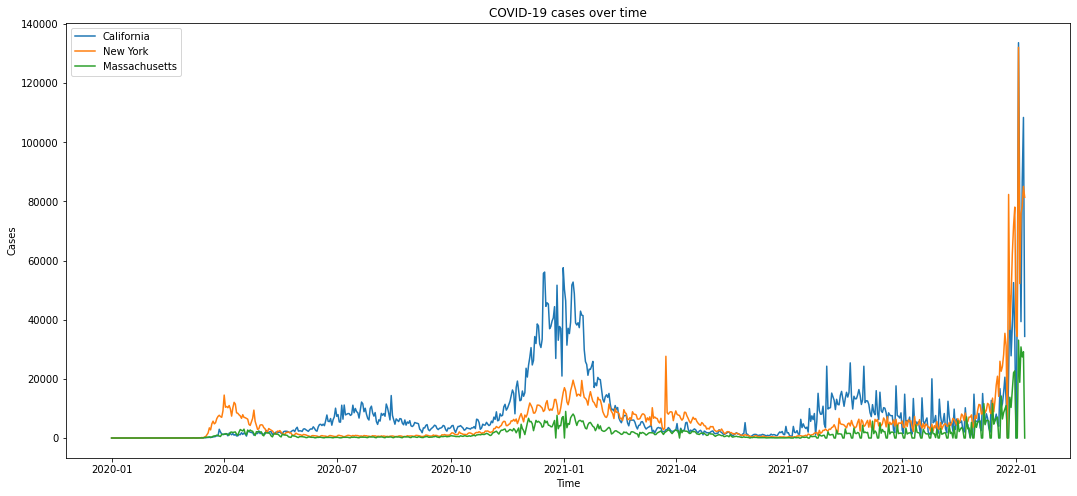

In [ ]:
fig = plt.subplots(1,1, figsize = (18,8))
plt.plot(california.index.values,california['JHU_cases'],label="California")
plt.plot(new_york.index.values,new_york['JHU_cases'],label="New York")
plt.plot(ma.index.values,ma['JHU_cases'],label="Massachusetts")
plt.xlabel('Time')
plt.ylabel('Cases')
plt.title('COVID-19 cases over time')
plt.legend()

## Prepare feature table and smooth data using rolling mean of new cases

We prepared feature table containing only Google Trends. We noticed that the confirmed case data was very ridged. Thus, in order to help the model learn and predict the true trend rather than being distracted by those jagged lines, we smoothed the outcome data using rolling mean of new cases with a window size of 5.

In [ ]:
#separate feature and outcome tables
cali_features=california.iloc[:,2:]
cali_outcomes=california.iloc[:,0]
ny_features=new_york.iloc[:,2:]
ny_outcomes=new_york.iloc[:,0]
ma_features=ma.iloc[:,2:]
ma_outcomes=ma.iloc[:,0]

#extract only google trend features
gt_cols=[]
for col in cali_features.columns:
  if "gt_" in col or "gt2_" in col:
    gt_cols.append(col)
cali_gt=cali_features[gt_cols]

gt_cols=[]
for col in ny_features.columns:
  if "gt_" in col or "gt2_" in col:
    gt_cols.append(col)
ny_gt=ny_features[gt_cols]

gt_cols=[]
for col in ma_features.columns:
  if "gt_" in col or "gt2_" in col:
    gt_cols.append(col)
ma_gt=ma_features[gt_cols]

In [ ]:
# Window == number of days in rolling window over which to calculate mean
window = 5
cali_outcomes = cali_outcomes.transform(lambda x: x.rolling(window).mean())
ny_outcomes = ny_outcomes.transform(lambda x: x.rolling(window).mean())
ma_outcomes = ma_outcomes.transform(lambda x: x.rolling(window).mean())

In [ ]:
cali_outcomes = cali_outcomes.fillna(0)
ny_outcomes = ny_outcomes.fillna(0)
ma_outcomes = ma_outcomes.fillna(0)

## Standardize the cases based on the population in the three states

**After standardization, the unit of our outcome became cases/1e5 people.**

Population data referred to: Bureau, US. "State Population Totals And Components Of Change: 2020-2021". Census.Gov, 2022, https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html.

In [ ]:
# cali_outcomes=cali_outcomes.apply(lambda x: x*100000/39499738)
# ny_outcomes=ny_outcomes.apply(lambda x: x*100000/20154933)
# ma_outcomes=ma_outcomes.apply(lambda x: x*100000/7022220)

Sanity check smoothing & standardization step by visualization. We plotted the number of cases for three states against time after smoothing and standardization.

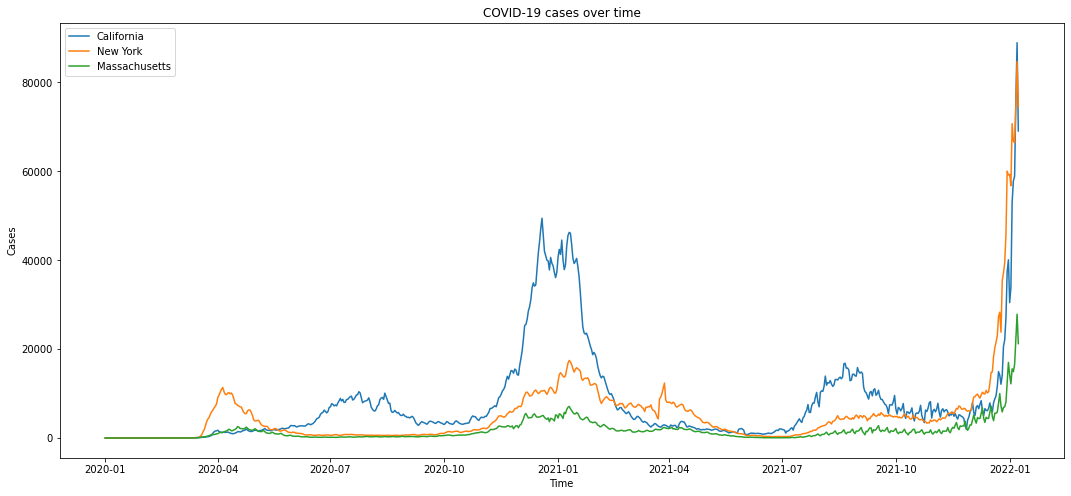

In [ ]:
fig = plt.subplots(1,1, figsize = (18,8))
plt.plot(california.index.values,cali_outcomes,label="California")
plt.plot(new_york.index.values,ny_outcomes,label="New York")
plt.plot(ma.index.values,ma_outcomes,label="Massachusetts")
plt.xlabel('Time')
plt.ylabel('Cases')
plt.title('COVID-19 cases over time')
plt.legend()

## Data Transformation

Taking the log transformation so that the time series could be more stationary.

In [ ]:
log_cali_outcomes = np.log(cali_outcomes+1)
log_ny_outcomes = np.log(ny_outcomes+1)
log_ma_outcomes = np.log(ma_outcomes+1)

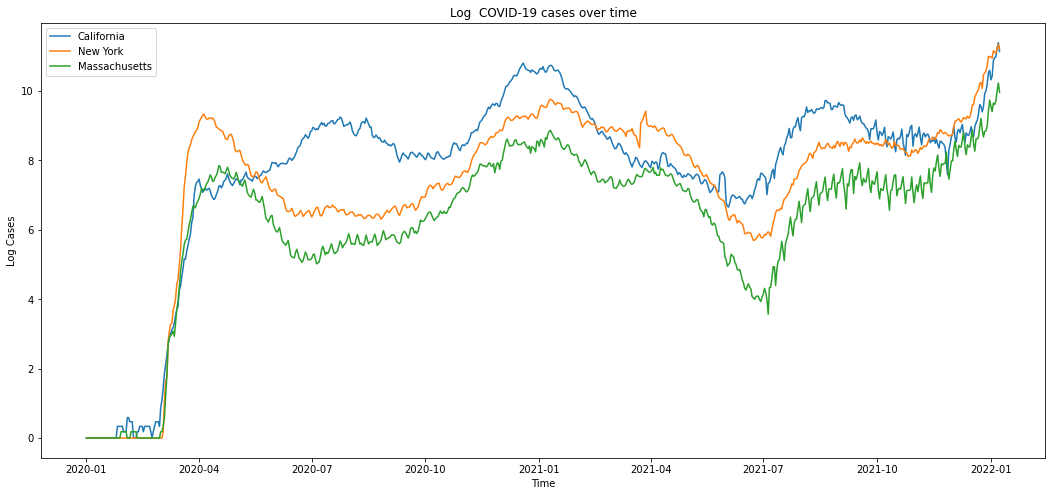

In [ ]:
fig = plt.subplots(1,1, figsize = (18,8))
plt.plot(california.index.values,log_cali_outcomes,label="California")
plt.plot(new_york.index.values,log_ny_outcomes,label="New York")
plt.plot(ma.index.values,log_ma_outcomes,label="Massachusetts")
plt.xlabel('Time')
plt.ylabel('Log Cases')
plt.title('Log  COVID-19 cases over time')
plt.legend()

## Data Imputation 

We imputed the remaining missing value in all features by using KNN imputer. 

In [ ]:
#imputation using KNN
col_names=cali_gt.columns
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(cali_gt)
imputed_data = imputer.transform(cali_gt)
imputed_cali_gt = pd.DataFrame(imputed_data,columns=col_names)

col_names=ny_gt.columns
imputer.fit(ny_gt)
imputed_data = imputer.transform(ny_gt)
imputed_ny_gt = pd.DataFrame(imputed_data,columns=col_names)

col_names=ma_gt.columns
imputer.fit(ma_gt)
imputed_data = imputer.transform(ma_gt)
imputed_ma_gt = pd.DataFrame(imputed_data,columns=col_names)

## Drop highly correlated features common among all three datasets

As a part of feature selection step, we dropped highly correlated features common among all three daatsets to reduce data dimensionallity, so as to reduce computation cost and improve model performance.

In [ ]:
#Drop highly correlated features common among all three datasets
imputed_cali_gt=imputed_cali_gt.drop(['gt2_Acute bronchitis','gt2_Cough',"gt2_Bell's palsy"],axis=1)
imputed_ny_gt=imputed_ny_gt.drop(['gt2_Acute bronchitis','gt2_Cough',"gt2_Bell's palsy"],axis=1)
imputed_ma_gt=imputed_ma_gt.drop(['gt2_Acute bronchitis','gt2_Cough',"gt2_Bell's palsy"],axis=1)

In [ ]:
imputed_cali_gt.shape, imputed_ny_gt.shape, imputed_ma_gt.shape

((739, 442), (739, 442), (739, 442))

In [ ]:
log_cali_outcomes.shape, log_ny_outcomes.shape, log_ma_outcomes.shape

((739,), (739,), (739,))

In [ ]:
log_cali_outcomes

date
2020-01-01     0.000000
2020-01-02     0.000000
2020-01-03     0.000000
2020-01-04     0.000000
2020-01-05     0.000000
                ...    
2022-01-04    10.965899
2022-01-05    10.983685
2022-01-06    11.241421
2022-01-07    11.395935
2022-01-08    11.143287
Name: JHU_cases, Length: 739, dtype: float64

### Remove cubic trend

In [ ]:
# # Define functions to calculate AIC and BIC
# from scipy.stats import norm 

# def evaluate_AIC(k, residuals):
#   """
#   Finds the AIC given the number of parameters estimated and 
#   the residuals of the model. Assumes residuals are distributed 
#   Gaussian with unknown variance. 
#   """
#   standard_deviation = np.std(residuals)
#   log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
#   return 2 * k - 2 * np.sum(log_likelihood)

# def evaluate_BIC(k, residuals):
#   """
#   Finds the AIC given the number of parameters estimated and 
#   the residuals of the model. Assumes residuals are distributed 
#   Gaussian with unknown variance. 
#   """
#   standard_deviation = np.std(residuals)
#   log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
#   return k * np.log(len(residuals)) - 2 * np.sum(log_likelihood)

In [ ]:
# # After linear fit, it seems like a higher order model is needed
# from sklearn import linear_model
# clf = linear_model.LinearRegression()
# index_len = len(log_cali_outcomes.index.values)
# index = np.linspace(1,index_len,index_len).reshape(-1,1)

# new_x = np.hstack((index, index ** 2, index ** 3))
# clf.fit(new_x, log_cali_outcomes)
# print(clf.coef_) 
# cubic_prediction = clf.predict(new_x)

# fig, axs = plt.subplots(2,1, figsize=(12,12))
# axs[0].plot(california.index.values, log_cali_outcomes, label='log COVID-19 cases (original data)')
# axs[0].plot(california.index.values, cubic_prediction, 'r', label='fitted line')
# axs[0].legend()
# axs[0].set_title("True Log Cases vs Fitted Cubic Line (CA)")
# cali_cubic_residuals = log_cali_outcomes - cubic_prediction
# axs[1].plot(california.index.values, cali_cubic_residuals, 'o')
# axs[1].set_title("Residuals: True Log Cases - Fitted Cubic Line")
# print("MSE with cubic fit:", np.mean((cali_cubic_residuals)**2))
# print("AIC:", evaluate_AIC(2, cali_cubic_residuals))
# print("BIC:", evaluate_BIC(2, cali_cubic_residuals))

In [ ]:
# # After linear fit, it seems like a higher order model is needed
# from sklearn import linear_model
# clf = linear_model.LinearRegression()
# index_len = len(log_ny_outcomes.index.values)
# index = np.linspace(1,index_len,index_len).reshape(-1,1)

# new_x = np.hstack((index, index ** 2, index ** 3))
# clf.fit(new_x, log_ny_outcomes)
# print(clf.coef_) 
# cubic_prediction = clf.predict(new_x)

# fig, axs = plt.subplots(2,1, figsize=(12,12))
# axs[0].plot(new_york.index.values, log_ny_outcomes, label='log COVID-19 cases (original data)')
# axs[0].plot(new_york.index.values, cubic_prediction, 'r', label='fitted line')
# axs[0].legend()
# axs[0].set_title("True Log Cases vs Fitted Cubic Line (NY)")
# ny_cubic_residuals = log_ny_outcomes - cubic_prediction
# axs[1].plot(new_york.index.values, ny_cubic_residuals, 'o')
# axs[1].set_title("Residuals: True Log Cases - Fitted Cubic Line")
# print("MSE with cubic fit:", np.mean((ny_cubic_residuals)**2))
# print("AIC:", evaluate_AIC(2, ny_cubic_residuals))
# print("BIC:", evaluate_BIC(2, ny_cubic_residuals))

In [ ]:
# # After linear fit, it seems like a higher order model is needed
# from sklearn import linear_model
# clf = linear_model.LinearRegression()
# index_len = len(log_ny_outcomes.index.values)
# index = np.linspace(1,index_len,index_len).reshape(-1,1)

# new_x = np.hstack((index, index ** 2, index ** 3))
# clf.fit(new_x, log_ny_outcomes)
# print(clf.coef_) 
# cubic_prediction = clf.predict(new_x)

# fig, axs = plt.subplots(2,1, figsize=(12,12))
# axs[0].plot(new_york.index.values, log_ny_outcomes, label='log COVID-19 cases (original data)')
# axs[0].plot(new_york.index.values, cubic_prediction, 'r', label='fitted line')
# axs[0].legend()
# axs[0].set_title("True Log Cases vs Fitted Cubic Line (NY)")
# ma_cubic_residuals = log_ny_outcomes - cubic_prediction
# axs[1].plot(new_york.index.values, ma_cubic_residuals, 'o')
# axs[1].set_title("Residuals: True Log Cases - Fitted Cubic Line")
# print("MSE with cubic fit:", np.mean((ma_cubic_residuals)**2))
# print("AIC:", evaluate_AIC(2, ma_cubic_residuals))
# print("BIC:", evaluate_BIC(2, ma_cubic_residuals))

# 3. Data Preparation for Time Series Forecasting

Since the gt features are in varies scales, we standardized the gt features by standard scaler.

In order to fit data into the RNN models, we first transformed two dimensional time-series data of shape [samples, features] into three dimensional structure of a shape [samples, time steps, features]. Specifically, we specified a time step of 14 days, then moved a sliding window of size [time steps, features] on the 2D dataset to capture the information for each time step and stacked them together to get a 3D data. Essentially, we add one dimension of time steps
to the original data. We defined the features as our predictors X, and the final 7-day COVID-19 cases for each 14-day period as our target Y, meaning that we used the features from every 14 days to predict the cases of the last 7 days. 

In [ ]:
def data_process(features, outcome):
    outcome = outcome.reset_index(drop = True)
    features = features.reset_index(drop = True)
    cols = features.columns
    standardizer = StandardScaler()
    standardizer.fit(features)
    scaled_features = pd.DataFrame(standardizer.transform(features),columns=cols)
    combo = pd.concat([scaled_features, outcome], axis = 1)
    combo["JHU_cases"] = combo["JHU_cases"].fillna(0)
    return combo

def times_series_split(time_series_df, response:str, days_train, days_pred, print_shape=False):
    
    # Initialize x, y arrays as zeroes
    # Decide if you want to hold out response variable
    x = np.zeros((0, days_train, time_series_df.shape[-1]-1))
    y = np.zeros((0, days_pred))
        
    # For every row in the dataframe
    for i in range(len(time_series_df)):
        
        # Define the windows of training and prediction
        idx_in = i + days_train
        idx_out = idx_in + days_pred
        
        # If window of prediction tries to go past end of data, stop
        if idx_out > len(time_series_df):
            break

        # Create windowed training sequence for all non-response columns
        seq_in = np.array(time_series_df.iloc[i:idx_in, time_series_df.columns != response])

        # Create windowed prediction sequence for response column
        response_idx = time_series_df.columns.get_loc(response)
        seq_out = np.array(time_series_df.iloc[idx_in:idx_out, response_idx])
        
        # Add sequences to respective array, shaped for supervised learning
        x = np.concatenate((x, seq_in.reshape(((1,)+seq_in.shape))), axis = 0)
        y = np.concatenate((y, seq_out.reshape(((1,)+seq_out.shape))), axis = 0)
        
    # Decide if you want to print the output shape for clarity
    if print_shape == True:
        print("x_train shape: ", x.shape, "y_train shape: ", y.shape)
    return np.array(x), np.array(y)

In [ ]:
# ca_combo = data_process(imputed_cali_gt, log_cali_outcomes)
ca_combo = data_process(imputed_cali_gt, log_cali_outcomes)
ny_combo = data_process(imputed_ny_gt, log_ny_outcomes)
ma_combo = data_process(imputed_ma_gt, log_ma_outcomes)

In [ ]:
days_train = 14
days_pred = 7
X_ca, y_ca = times_series_split(ca_combo, "JHU_cases", days_train, days_pred)
X_ny, y_ny = times_series_split(ny_combo, "JHU_cases", days_train, days_pred)
X_ma, y_ma = times_series_split(ma_combo, "JHU_cases", days_train, days_pred)
features_ca = X_ca.shape[-1]
features_ny = X_ny.shape[-1]
features_ma = X_ma.shape[-1]

In [ ]:
X_ca.shape, y_ca.shape

((719, 14, 442), (719, 7))

# 4. Recurrent Models for Forecasting COVID-19 New Cases

## Baseline Model - Simple RNN

As a baseline, we built a simple Recurrent Neural Networks (RNNs) model with a single 100 units layer to forecast the COVID-19 case number in the future, because RNNs are not only relatively easy to implement but also able to automatically learn the temporal dependencies.

## Advanced Models - LSTM & BiLSTM

LSTM is specifically designed for sequence data. It reads one time step of the sequence at a time and builds up an internal state representation that can be used as a learned context for making a prediction. Bidirectional LSTM can be beneficial to allow the LSTM model to learn the input sequence both forward and backwards and concatenate both interpretations. Therefore, we first designed a single layer LSTM model with 100 units, and then tried a bidirectional LSTM model with a single LSTM layer wrapped by a bidirectional wrapper layer.

## Design

We used ReLU activation function on each hidden layer, Adam optimizer with 0.001 learning rate, and Mean Square Error (MSE) loss. To make the models comparable, we only used California dataset. we used the trained models to make predictions and visualized the prediction performance overlapped with the true cases.

In [ ]:
# Define RNN model
def model_rnn(days_train, days_pred, features, summary=True):
    
    rnn = Sequential()
    # rnn.add(SimpleRNN(100, input_shape=(days_train, features), return_sequences=True))
    rnn.add(SimpleRNN(100, input_shape=(days_train, features), return_sequences=False))
    rnn.add(Dense(days_pred, activation="linear"))
    
    rnn.compile(optimizer=Adam(), loss='mse')

    if summary == True:
        rnn.summary()
    
    return rnn

# Define LSTM model
def model_lstm(days_train, days_pred, features, summary=True):

    lstm = Sequential()
    lstm.add(LSTM(200, activation='relu', return_sequences=False, input_shape=(days_train, features)))
    lstm.add(Dense(days_pred, activation="linear"))
    
    lstm.compile(optimizer=Adam(), loss='mse')

    if summary == True:
        lstm.summary()
    
    return lstm

# Define Bidirectional LSTM model
def model_lstm_bd(days_train, days_pred, features, summary=True):

    lstm_bd = Sequential()
    lstm_bd.add(Bidirectional(LSTM(200, activation='relu', return_sequences=False), input_shape=(days_train, features)))
    lstm_bd.add(Dense(days_pred, activation="linear"))
    
    lstm_bd.compile(optimizer=Adam(), loss='mse')

    if summary == True:
        lstm_bd.summary()
    
    return lstm_bd

# Define function to train an inputted model
def fit_model(model, x_train, y_train, val_split=0.0, epochs=10, verbose=1, batch_size=1, cb = []):
    history = model.fit(x_train, y_train, #validation_split=val_split,
                        epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks = cb)
    return history

# Define function to plot single-day prediction
def plot_prediction(prediction, y_train, scale_max, ax=None):
    
    # Rescale data
    prediction_rescaled = prediction * scale_max
    y_train_rescaled = y_train * scale_max

    # Plot figure
    if ax is not None:
        plot_loc=ax
    else:
        plot_loc=plt
        plt.figure(figsize=(20,10))

    plot_loc.plot(y_train_rescaled, label="Actual")
    plot_loc.plot(prediction_rescaled, ls='--', label="Prediction")
    
    if ax is None:
        plt.legend(fontsize=15, loc=2)
        # plt.title(f"Plotting {response} over time", size=20)
        plt.xlabel("Days since first case", size=15)

# Define function to allow windowed prediction plotting
# when predicting multiple days into the future
def plot_multiday_predictions(y_train, predictions, scale_max, ax=None, skip = 1):

    # Rescale data
    predictions_rescaled = predictions * scale_max
    y_train_rescaled = y_train * scale_max
    
    # Plot actual data
    cas_obs = []
    for i in range(len(y_train_rescaled)):
        cas_obs.append(y_train_rescaled[i, 0])
    
    if ax is not None:
        plot_loc=ax
    else:
        plot_loc=plt
        plt.figure(figsize=(20,10))
        
    plot_loc.plot(np.arange(0, len(cas_obs)), cas_obs, label = 'Observed')
    for i in range(len(predictions_rescaled)):
        if i % skip != 0:
            continue
        plot_loc.plot(np.arange(i, i+predictions_rescaled.shape[-1]), predictions_rescaled[i], c = 'orange')
        
    if ax is None:
        plt.legend(['Observed', 'Predicted'], fontsize=15, loc=2)

# Define function to predict
def predict_model(model, x_test):
    prediction = model.predict(x_test)
    return prediction

In [ ]:
# es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0)
lcall = LambdaCallback(on_epoch_end=lambda epoch, logs: print("epoch " + str(epoch) + ", loss " + str(logs['loss'])) if epoch % 20 == 0 else None)

### Train Models for CA

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               54300     
                                                                 
 dense (Dense)               (None, 7)                 707       
                                                                 
Total params: 55,007
Trainable params: 55,007
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 58.613128662109375
epoch 20, loss 0.22951264679431915
epoch 40, loss 0.059293050318956375
epoch 60, loss 0.03211390972137451
epoch 80, loss 0.02523738704621792
epoch 100, loss 0.02290790155529976
epoch 120, loss 0.016555501148104668
epoch 140, loss 0.016637032851576805


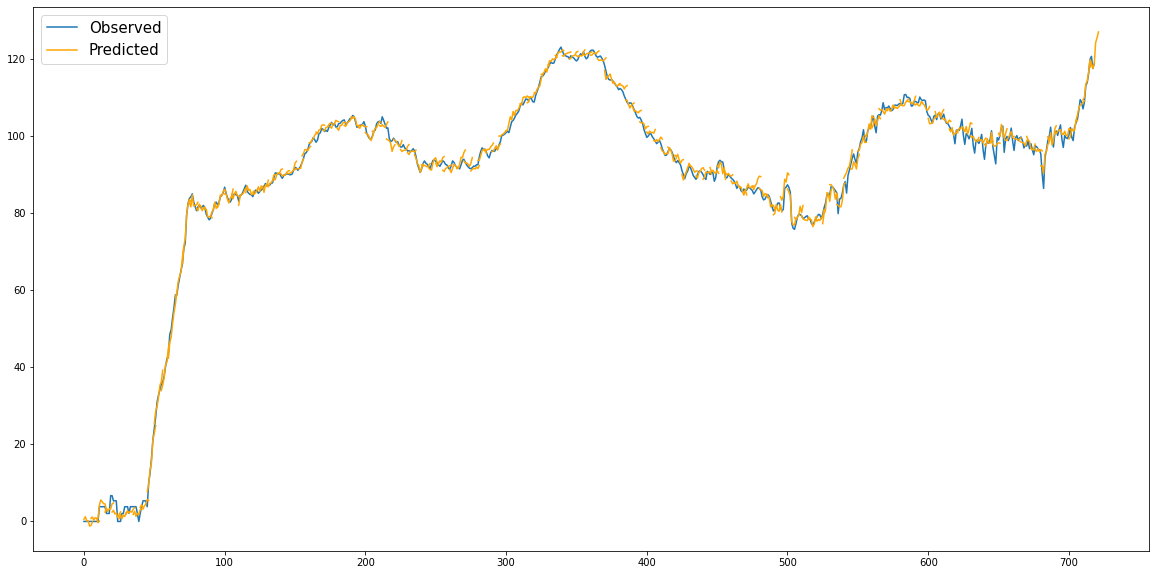

In [ ]:
# Simple RNN
rnn = model_rnn(days_train, days_pred, features_ca)
history_rnn = fit_model(rnn, X_ca, y_ca, val_split=0.2, epochs = 150, batch_size = 16, cb = [lcall], verbose = 0)
rnn_pred_ca = predict_model(rnn, X_ca)
plot_multiday_predictions(y_ca, rnn_pred_ca, max(ca_combo['JHU_cases']), skip = 5)

In [ ]:
rescale_rnn_pred_ca = rnn_pred_ca * max(ca_combo['JHU_cases'])
rescale_y_ca = y_ca * max(ca_combo['JHU_cases'])

rnn_ca_mse = mean_squared_error(rescale_rnn_pred_ca.flatten(), rescale_y_ca.flatten())
print(f"MSE of RNN: {rnn_ca_mse:.4f}")

MSE of RNN: 2.0706


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               514400    
                                                                 
 dense_1 (Dense)             (None, 7)                 1407      
                                                                 
Total params: 515,807
Trainable params: 515,807
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 8.598601341247559
epoch 20, loss 0.0312747098505497
epoch 40, loss 0.018838820978999138
epoch 60, loss 0.027316557243466377
epoch 80, loss 0.006583207752555609
epoch 100, loss 0.006925045046955347
epoch 120, loss 0.009883992373943329
epoch 140, loss 0.011892319656908512


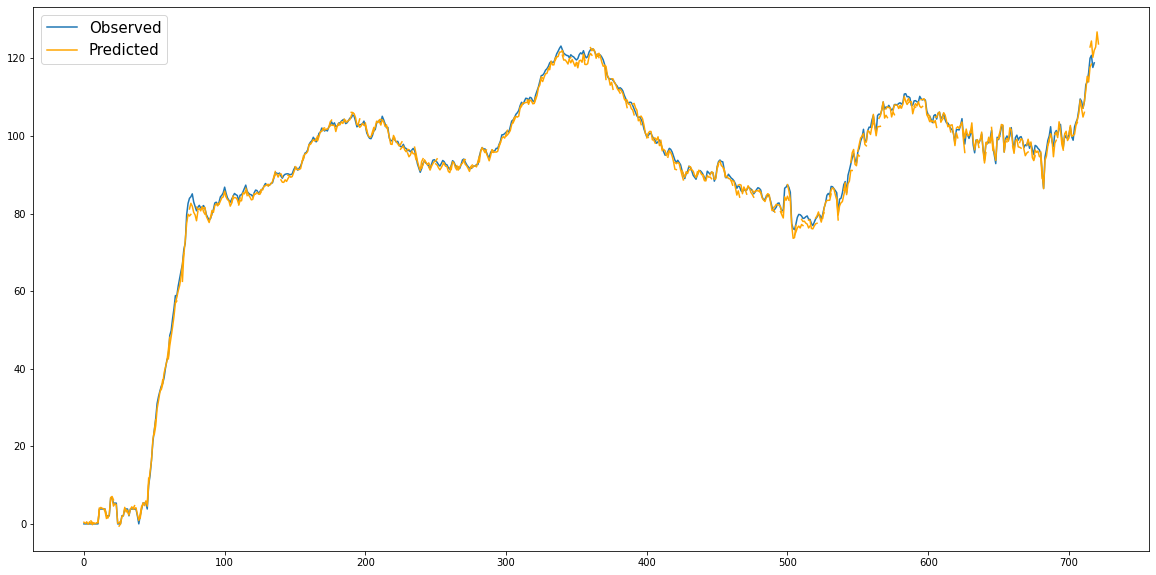

In [ ]:
# LSTM
lstm = model_lstm(days_train, days_pred, features_ca)
history_lstm = fit_model(lstm, X_ca, y_ca, val_split=0.2, epochs = 150, batch_size = 16, cb = [lcall], verbose = 0)
lstm_pred_ca = predict_model(lstm, X_ca)
plot_multiday_predictions(y_ca, lstm_pred_ca, max(ca_combo['JHU_cases']), skip = 5)

In [ ]:
rescale_lstm_pred_ca = lstm_pred_ca * max(ca_combo['JHU_cases'])
rescale_y_ca = y_ca * max(ca_combo['JHU_cases'])

lstm_ca_mse = mean_squared_error(rescale_lstm_pred_ca.flatten(), rescale_y_ca.flatten())
print(f"MSE of lstm: {lstm_ca_mse:.4f}")

MSE of lstm: 1.2585


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 400)              1028800   
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 7)                 2807      
                                                                 
Total params: 1,031,607
Trainable params: 1,031,607
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 7.768661975860596
epoch 20, loss 0.019805850461125374
epoch 40, loss 0.010429052636027336
epoch 60, loss 0.04223049432039261
epoch 80, loss 0.01510663889348507
epoch 100, loss 0.001782926614396274
epoch 120, loss 0.0035588969476521015
epoch 140, loss 0.0016353704268112779


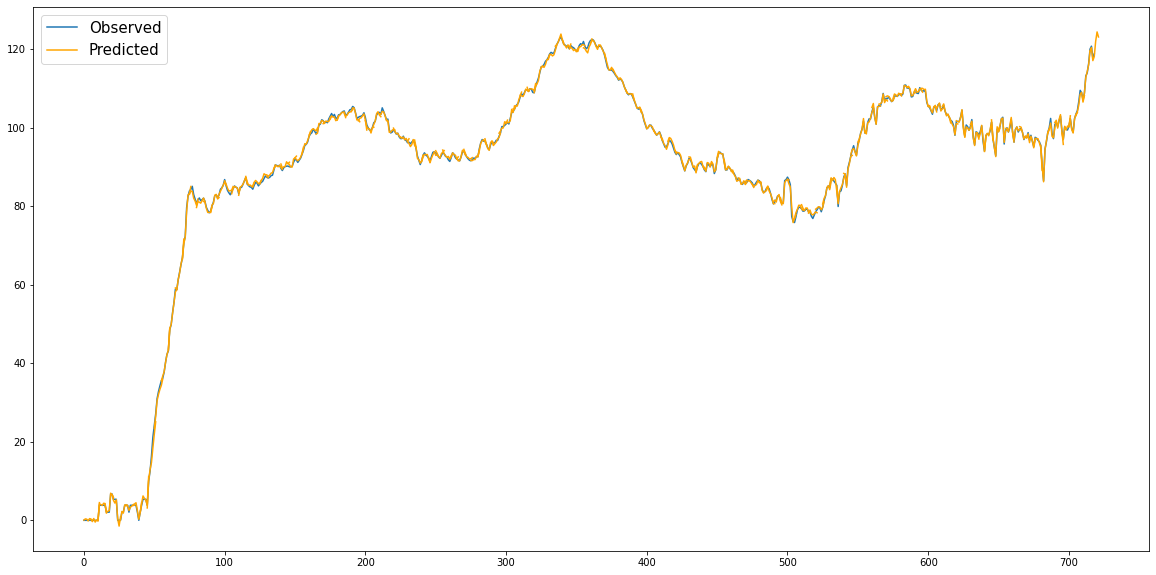

In [ ]:
# bidirectional LSTM
bd_lstm = model_lstm_bd(days_train, days_pred, features_ca)
history_bd_lstm = fit_model(bd_lstm, X_ca, y_ca, val_split=0.2, epochs = 150, batch_size = 16, cb = [lcall], verbose = 0)
bd_lstm_pred_ca = predict_model(bd_lstm, X_ca)
plot_multiday_predictions(y_ca, bd_lstm_pred_ca, max(ca_combo['JHU_cases']), skip = 5)

In [ ]:
rescale_bd_lstm_pred_ca = bd_lstm_pred_ca * max(ca_combo['JHU_cases'])
rescale_y_ca = y_ca * max(ca_combo['JHU_cases'])

bd_lstm_ca_mse = mean_squared_error(rescale_bd_lstm_pred_ca.flatten(), rescale_y_ca.flatten())
print(f"MSE of bilstm: {bd_lstm_ca_mse:.4f}")

MSE of bilstm: 0.2147


Performance of CA models:

* MSE of RNN: 2.0706
* MSE of lstm: 1.2585
* MSE of bilstm: 0.2147

### Train Models for NY

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 100)               54300     
                                                                 
 dense_3 (Dense)             (None, 7)                 707       
                                                                 
Total params: 55,007
Trainable params: 55,007
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 48.351192474365234
epoch 20, loss 0.1269039511680603
epoch 40, loss 0.04356224089860916
epoch 60, loss 0.02314002998173237
epoch 80, loss 0.014203010126948357
epoch 100, loss 0.009618483483791351
epoch 120, loss 0.010897958651185036
epoch 140, loss 0.006732679437845945


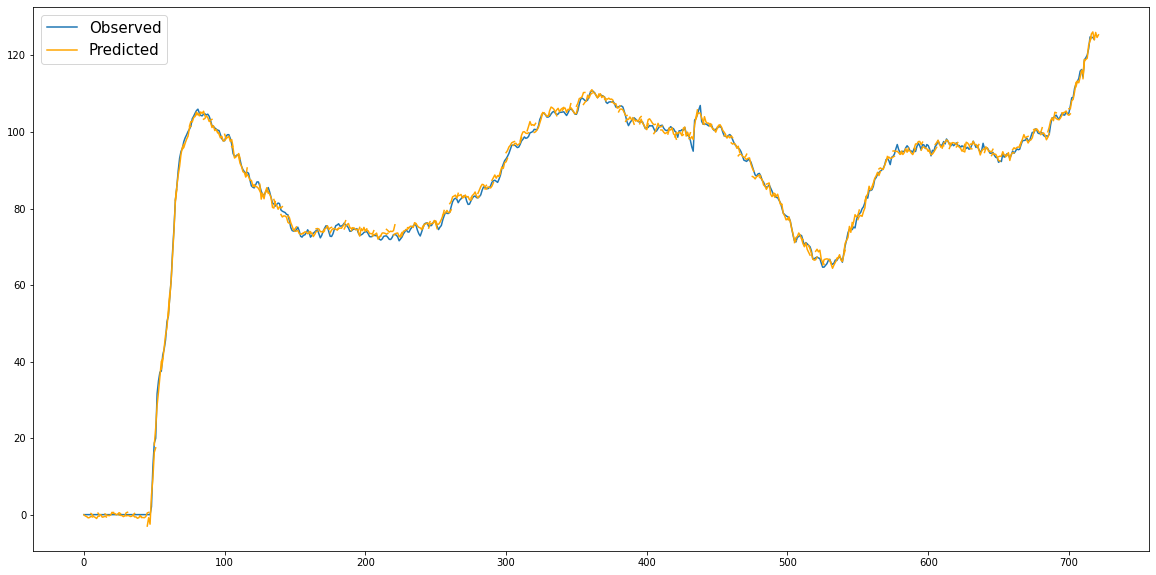

In [ ]:
# Simple RNN
rnn = model_rnn(days_train, days_pred, features_ny)
history_rnn = fit_model(rnn, X_ny, y_ny, val_split=0.2, epochs = 150, batch_size = 16, cb = [lcall], verbose = 0)
rnn_pred_ny = predict_model(rnn, X_ny)
plot_multiday_predictions(y_ny, rnn_pred_ny, max(ny_combo['JHU_cases']), skip = 5)

In [ ]:
rescale_rnn_pred_ny = rnn_pred_ny * max(ny_combo['JHU_cases'])
rescale_y_ny = y_ny * max(ny_combo['JHU_cases'])

rnn_ny_mse = mean_squared_error(rescale_rnn_pred_ny.flatten(), rescale_y_ny.flatten())
print(f"MSE of RNN: {rnn_ny_mse:.4f}")

MSE of RNN: 0.8664


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200)               514400    
                                                                 
 dense_4 (Dense)             (None, 7)                 1407      
                                                                 
Total params: 515,807
Trainable params: 515,807
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 8.022356033325195
epoch 20, loss 0.03903598710894585
epoch 40, loss 0.016437100246548653
epoch 60, loss 0.01366433221846819
epoch 80, loss 0.007892644964158535
epoch 100, loss 0.0179436132311821
epoch 120, loss 0.005774795543402433
epoch 140, loss 0.004703138489276171


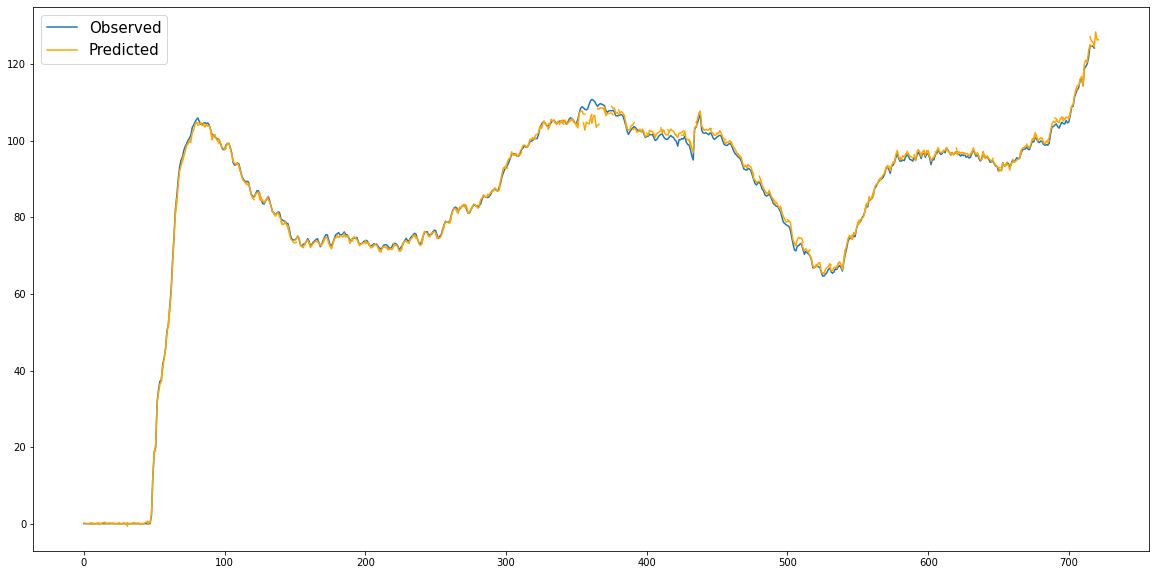

In [ ]:
# LSTM
lstm = model_lstm(days_train, days_pred, features_ny)
history_lstm = fit_model(lstm, X_ny, y_ny, val_split=0.2, epochs = 150, batch_size = 16, cb = [lcall], verbose = 0)
lstm_pred_ny = predict_model(lstm, X_ny)
plot_multiday_predictions(y_ny, lstm_pred_ny, max(ny_combo['JHU_cases']), skip = 5)

In [ ]:
rescale_lstm_pred_ny = lstm_pred_ny * max(ny_combo['JHU_cases'])
rescale_y_ny = y_ny * max(ny_combo['JHU_cases'])

lstm_ny_mse = mean_squared_error(rescale_lstm_pred_ny.flatten(), rescale_y_ny.flatten())
print(f"MSE of lstm: {lstm_ny_mse:.4f}")

MSE of lstm: 0.8847


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 400)              1028800   
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 7)                 2807      
                                                                 
Total params: 1,031,607
Trainable params: 1,031,607
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 8.896117210388184
epoch 20, loss 0.05103824660181999
epoch 40, loss 0.040657591074705124
epoch 60, loss 0.02200501784682274
epoch 80, loss 0.02281026355922222
epoch 100, loss 0.00427887961268425
epoch 120, loss 0.006005458999425173
epoch 140, loss 0.009778871200978756


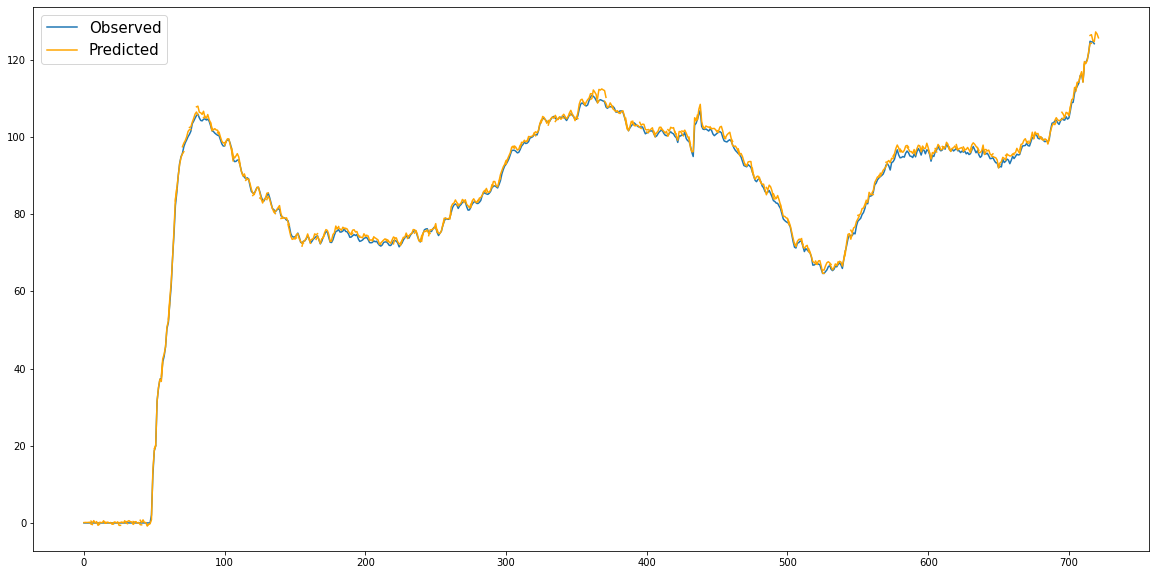

In [ ]:
# bidirectional LSTM
bd_lstm = model_lstm_bd(days_train, days_pred, features_ny)
history_bd_lstm = fit_model(bd_lstm, X_ny, y_ny, val_split=0.2, epochs = 150, batch_size = 16, cb = [lcall], verbose = 0)
bd_lstm_pred_ny = predict_model(bd_lstm, X_ny)
plot_multiday_predictions(y_ny, bd_lstm_pred_ny, max(ny_combo['JHU_cases']), skip = 5)

In [ ]:
rescale_bd_lstm_pred_ny = bd_lstm_pred_ny * max(ca_combo['JHU_cases'])
rescale_y_ny = y_ny * max(ny_combo['JHU_cases'])

bd_lstm_ny_mse = mean_squared_error(rescale_bd_lstm_pred_ny.flatten(), rescale_y_ny.flatten())
print(f"MSE of bilstm: {bd_lstm_ny_mse:.4f}")

MSE of bilstm: 1.1922


Performance of NY models:
* MSE of RNN: 0.8664
* MSE of lstm: 0.8847
* MSE of bilstm: 1.1922

### Train Models for MA

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 100)               54300     
                                                                 
 dense_6 (Dense)             (None, 7)                 707       
                                                                 
Total params: 55,007
Trainable params: 55,007
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 36.55411911010742
epoch 20, loss 0.15631215274333954
epoch 40, loss 0.05064760893583298
epoch 60, loss 0.029268354177474976
epoch 80, loss 0.020225435495376587
epoch 100, loss 0.0197617094963789
epoch 120, loss 0.013548103161156178
epoch 140, loss 0.010430244728922844


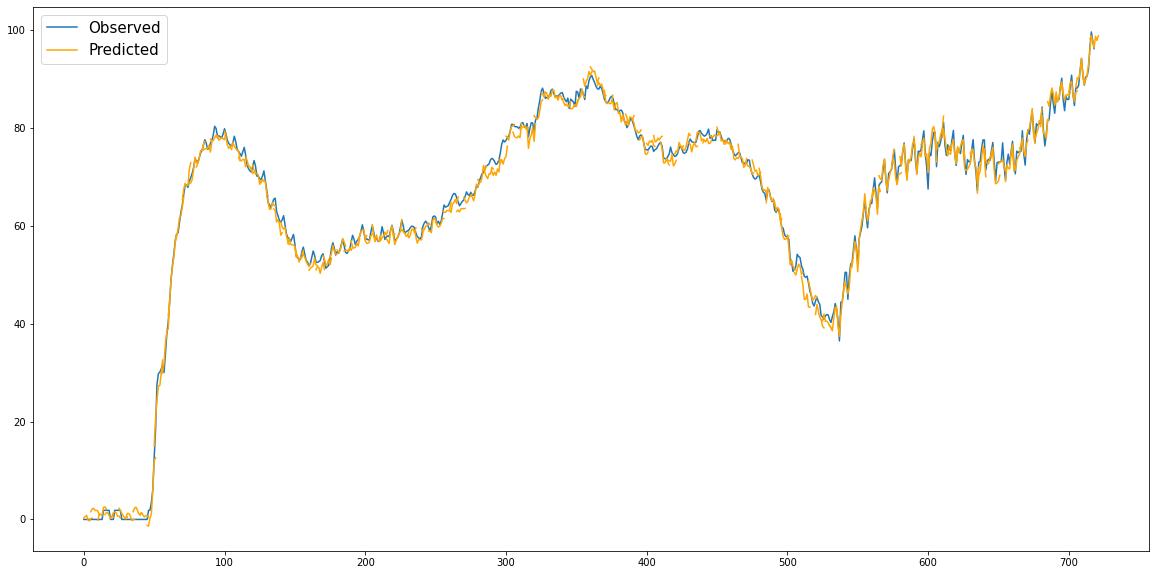

In [ ]:
# Simple RNN
rnn = model_rnn(days_train, days_pred, features_ma)
history_rnn = fit_model(rnn, X_ma, y_ma, val_split=0.2, epochs = 150, batch_size = 16, cb = [lcall], verbose = 0)
rnn_pred_ma = predict_model(rnn, X_ma)
plot_multiday_predictions(y_ma, rnn_pred_ma, max(ma_combo['JHU_cases']), skip = 5)

In [ ]:
rescale_rnn_pred_ma = rnn_pred_ma * max(ma_combo['JHU_cases'])
rescale_y_ma = y_ma * max(ma_combo['JHU_cases'])

rnn_ma_mse = mean_squared_error(rescale_rnn_pred_ma.flatten(), rescale_y_ma.flatten())
print(f"MSE of RNN: {rnn_ma_mse:.4f}")

MSE of RNN: 1.7764


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 200)               514400    
                                                                 
 dense_7 (Dense)             (None, 7)                 1407      
                                                                 
Total params: 515,807
Trainable params: 515,807
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 6.503179550170898
epoch 20, loss 0.07028670608997345
epoch 40, loss 0.0225752554833889
epoch 60, loss 0.002585475565865636
epoch 80, loss 0.005969495978206396
epoch 100, loss 0.01575239934027195
epoch 120, loss 0.007356947287917137
epoch 140, loss 0.0048142788000404835


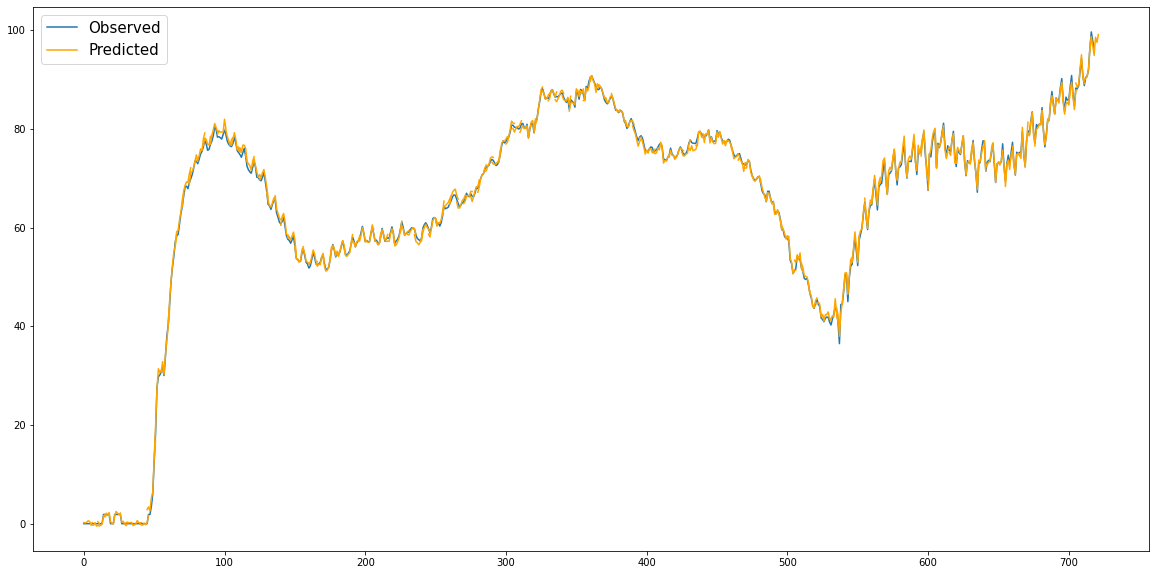

In [ ]:
# LSTM
lstm = model_lstm(days_train, days_pred, features_ma)
history_lstm = fit_model(lstm, X_ma, y_ma, val_split=0.2, epochs = 150, batch_size = 16, cb = [lcall], verbose = 0)
lstm_pred_ma = predict_model(lstm, X_ma)
plot_multiday_predictions(y_ma, lstm_pred_ma, max(ma_combo['JHU_cases']), skip = 5)

In [ ]:
rescale_lstm_pred_ma = lstm_pred_ma * max(ma_combo['JHU_cases'])
rescale_y_ma = y_ma * max(ma_combo['JHU_cases'])

lstm_ma_mse = mean_squared_error(rescale_lstm_pred_ma.flatten(), rescale_y_ma.flatten())
print(f"MSE of lstm: {lstm_ma_mse:.4f}")

MSE of lstm: 0.4323


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 400)              1028800   
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 7)                 2807      
                                                                 
Total params: 1,031,607
Trainable params: 1,031,607
Non-trainable params: 0
_________________________________________________________________
epoch 0, loss 4.813594341278076
epoch 20, loss 0.018460387364029884
epoch 40, loss 0.008783896453678608
epoch 60, loss 0.007196728140115738
epoch 80, loss 0.021714413538575172
epoch 100, loss 0.005660197697579861
epoch 120, loss 0.012743073515594006
epoch 140, loss 0.004193501081317663


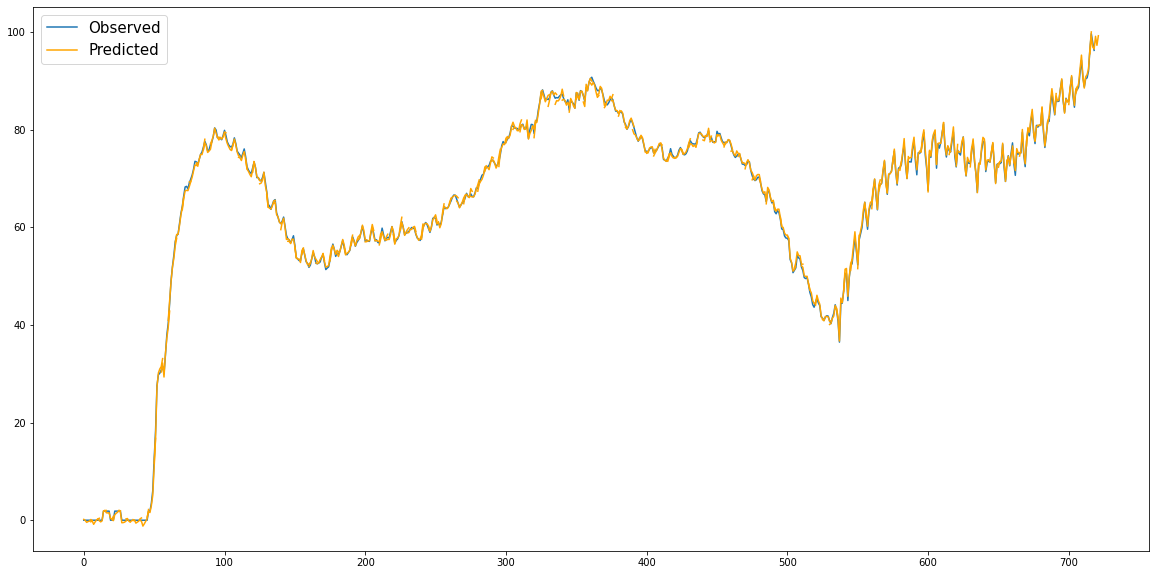

In [ ]:
# bidirectional LSTM
bd_lstm = model_lstm_bd(days_train, days_pred, features_ma)
history_bd_lstm = fit_model(bd_lstm, X_ma, y_ma, val_split=0.2, epochs = 150, batch_size = 16, cb = [lcall], verbose = 0)
bd_lstm_pred_ma = predict_model(bd_lstm, X_ma)
plot_multiday_predictions(y_ma, bd_lstm_pred_ma, max(ma_combo['JHU_cases']), skip = 5)

In [ ]:
rescale_bd_lstm_pred_ma = bd_lstm_pred_ma * max(ma_combo['JHU_cases'])
rescale_y_ma = y_ma * max(ma_combo['JHU_cases'])

bd_lstm_ma_mse = mean_squared_error(rescale_bd_lstm_pred_ma.flatten(), rescale_y_ma.flatten())
print(f"MSE of bilstm: {bd_lstm_ma_mse:.4f}")

MSE of bilstm: 0.2919


Performance of MA models:
* MSE of RNN: 1.7764
* MSE of lstm: 0.4323
* MSE of bilstm: 0.2919

# 6. Calculate feature importance measured by Mean Squared Error (MSE) through shuffling features on at a time in LSTM models

Reference: https://www.kaggle.com/code/cdeotte/lstm-feature-importance/notebook

In [ ]:
def feature_importance(model, X_ca, y_ca, COLS, top_num, model_name, results = None):
    
    if not results:
        results = []
        print(' Computing feature importance...')

        # COMPUTE BASELINE (NO SHUFFLE)
        base_preds = predict_model(model, X_ca)
        baseline_mse = mean_squared_error(base_preds, y_ca)
        results.append({'feature':'BASELINE','mse':baseline_mse}) 

        for k in range(len(COLS)):            
            # SHUFFLE FEATURE K
            save_col = X_ca[:,:,k].copy()
            np.random.shuffle(X_ca[:,:,k])
                                    
            # COMPUTE prediction MAE WITH FEATURE K SHUFFLED
            shuf_preds = predict_model(model, X_ca)
            #   mae = np.mean(np.abs( shuf_preds-y_ca ))
            mse = mean_squared_error(shuf_preds, y_ca)
            results.append({'feature':COLS[k],'mse':mse})
            X_ca[:,:,k] = save_col
    else:
        # COMPUTE BASELINE (NO SHUFFLE)
        base_preds = predict_model(model, X_ca)
        baseline_mse = mean_squared_error(base_preds, y_ca)
    df = pd.DataFrame(results)
    df = df.sort_values('mse')
    df = df.reset_index(drop = True)[-top_num:]
    plt.figure(figsize=(5,8))
    plt.barh(np.arange(len(df)),df.mse)
    plt.yticks(np.arange(len(df)),df.feature.values)
    plt.title(model_name + 'Feature Importance',size=16)
    plt.ylim((-1,len(df)))
    plt.plot([baseline_mse, baseline_mse],[-1,len(df)], '--', color='orange',label=f'Baseline \nMSE={baseline_mse:.3f}')
    plt.ylabel('Feature',size=14)
    plt.legend()
    plt.show()
    return results

 Computing feature importance...


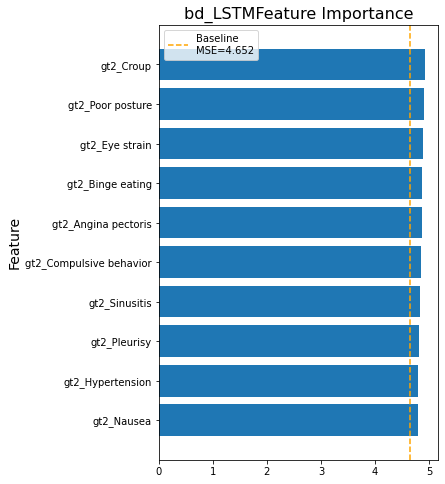

In [ ]:
re_bd_lstm = feature_importance(bd_lstm, X_ca, y_ca, list(imputed_cali_gt.columns), 10, "bd_LSTM", None)